# 4.5 - Transposed convolutions

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard
import pickle, bz2
from skimage import io
from sklearn.datasets import *
from local.lib import mlutils
from time import time
tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.4.1'

## Experiment with convolutions using them directly

See

- [Up-sampling with Transposed Convolution](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)
- [Types of convolution](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)
- [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)
- [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)


**Convolution 2D**

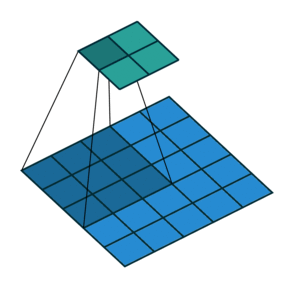

In [5]:
from IPython.display import display, Image
with open('local/imgs/convolution2d.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**Convolution 2D Transposed**


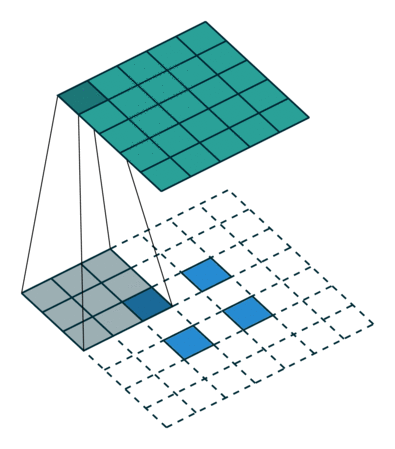

In [6]:
with open('local/imgs/convolution2d-transposed.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

### 2d convolution

load an image and one filter

255 0


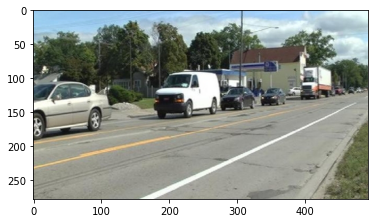

In [7]:
img = io.imread("local/imgs/cars-driving.jpg")
plt.imshow(img)
print (img.max(), img.min())

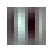

In [8]:
alex_c12 = pickle.load(bz2.BZ2File("local/data/alexnet_conv1_conv2.pklz", "r"), encoding="bytes")
filter_number = 90
akernel = alex_c12[b"conv1"][0][:,:,:,filter_number]
abias   = alex_c12[b"conv1"][1][filter_number]
plt.figure(figsize=(.7,.7))
plt.imshow((akernel-np.min(akernel))/(np.max(akernel)-np.min(akernel)))
plt.axis("off");

In [9]:
akernel.shape

(11, 11, 3)

observe how we do one convolution, setting the weights with the filter we just loaded

In [10]:
c2 = tf.keras.layers.Conv2D(filters=1, kernel_size=(11,11), activation="linear", dtype=tf.float64)
c2.build(input_shape=(None, *img.shape))

In [11]:
w = c2.get_weights()
[i.shape for i in w]

[(11, 11, 3, 1), (1,)]

In [12]:
w[0] = akernel[:,:,:,None]
c2.set_weights(w)

In [13]:
output_img = c2(img[None,:,:,:]/255)

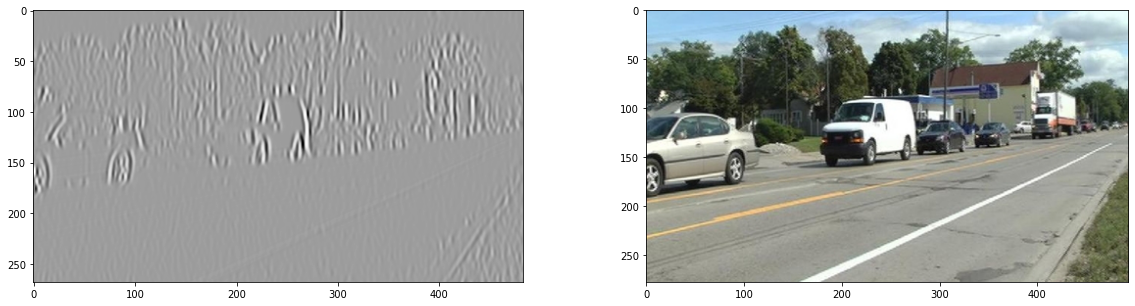

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(output_img[0,:,:,0], cmap=plt.cm.Greys_r)
plt.subplot(122)
plt.imshow(img)

### 1d convolution

observe how we simply apply an untrained layer

In [15]:
input_shape = (None, 6, 1)
c1 = tf.keras.layers.Conv1D(filters=2, kernel_size=3, activation="tanh")
c1.build(input_shape=input_shape)
c1.get_weights()

[array([[[-0.58414793,  0.6564418 ]],
 
        [[ 0.26771164,  0.7640059 ]],
 
        [[-0.6514672 , -0.52539873]]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [16]:
size=7
X = np.random.randint(3, size=[size]+list(input_shape)[1:]).astype(np.float32)
X.shape

(7, 6, 1)

In [17]:
X[:,:,0]

array([[2., 0., 0., 1., 1., 1.],
       [1., 0., 2., 0., 2., 1.],
       [2., 0., 2., 1., 0., 2.],
       [1., 2., 1., 2., 1., 2.],
       [2., 0., 1., 1., 1., 2.],
       [2., 0., 1., 1., 2., 0.],
       [2., 2., 0., 1., 1., 1.]], dtype=float32)

In [18]:
X[0,:,0]

array([2., 0., 0., 1., 1., 1.], dtype=float32)

In [19]:
output = c1(X).numpy()
print (output.shape)
output

(7, 4, 2)


array([[[-0.82372516,  0.8650032 ],
        [-0.57265687, -0.48185602],
        [-0.36596447,  0.2341797 ],
        [-0.7477816 ,  0.71387863]],

       [[-0.95511776, -0.3751091 ],
        [ 0.48951572,  0.91008365],
        [-0.9858272 ,  0.25624573],
        [-0.1155258 ,  0.7626894 ]],

       [[-0.9858272 ,  0.25624573],
        [-0.1155258 ,  0.7626894 ],
        [-0.7165823 ,  0.9690758 ],
        [-0.95511776, -0.3751091 ]],

       [[-0.6044895 ,  0.9300898 ],
        [-0.9759112 ,  0.7723363 ],
        [-0.6044895 ,  0.9300898 ],
        [-0.9759112 ,  0.7723363 ]],

       [[-0.94881487,  0.6569818 ],
        [-0.36596447,  0.2341797 ],
        [-0.7477816 ,  0.71387863],
        [-0.92453283,  0.35368574]],

       [[-0.94881487,  0.6569818 ],
        [-0.36596447,  0.2341797 ],
        [-0.92453283,  0.35368574],
        [-0.04868612,  0.97498655]],

       [[-0.56002706,  0.9932083 ],
        [-0.94881487,  0.6569818 ],
        [-0.36596447,  0.2341797 ],
        [-0.7477

### doing the convolution by hand


In [20]:
kernels, bias = c1.get_weights()
kernels.shape, bias.shape

((3, 1, 2), (2,))

**first filter output**

In [21]:
output[:,:,0]

array([[-0.82372516, -0.57265687, -0.36596447, -0.7477816 ],
       [-0.95511776,  0.48951572, -0.9858272 , -0.1155258 ],
       [-0.9858272 , -0.1155258 , -0.7165823 , -0.95511776],
       [-0.6044895 , -0.9759112 , -0.6044895 , -0.9759112 ],
       [-0.94881487, -0.36596447, -0.7477816 , -0.92453283],
       [-0.94881487, -0.36596447, -0.92453283, -0.04868612],
       [-0.56002706, -0.94881487, -0.36596447, -0.7477816 ]],
      dtype=float32)

**first filter**

In [22]:
kernels[:,0,0]

array([-0.58414793,  0.26771164, -0.6514672 ], dtype=float32)

**first filter applied manually to the first input row**

In [23]:
[np.tanh(kernels[:,0,0].dot(X[0,i:i+3,0])) for i in range(4)]

[-0.8237251, -0.5726568, -0.3659645, -0.7477816]

**now for all the input elements and filters**

the loop is for each convolution step

In [24]:
kernel, bias = c1.get_weights()
outputh = np.r_[[np.tanh(X[:,i:i+kernel.shape[0],0].dot(kernel[:,0,:])+bias) \
            for i in range(X.shape[1]-kernel.shape[0]+1)]].swapaxes(0,1).reshape(output.shape)
outputh

array([[[-0.8237251 ,  0.8650032 ],
        [-0.5726568 , -0.48185605],
        [-0.3659645 ,  0.23417974],
        [-0.7477816 ,  0.71387863]],

       [[-0.9551178 , -0.3751091 ],
        [ 0.48951578,  0.9100838 ],
        [-0.98582715,  0.25624576],
        [-0.11552583,  0.7626894 ]],

       [[-0.98582715,  0.25624576],
        [-0.11552583,  0.7626894 ],
        [-0.7165823 ,  0.96907574],
        [-0.9551178 , -0.3751091 ]],

       [[-0.60448956,  0.9300898 ],
        [-0.9759112 ,  0.77233624],
        [-0.60448956,  0.9300898 ],
        [-0.9759112 ,  0.77233624]],

       [[-0.9488148 ,  0.6569818 ],
        [-0.3659645 ,  0.23417974],
        [-0.7477816 ,  0.71387863],
        [-0.9245329 ,  0.35368577]],

       [[-0.9488148 ,  0.6569818 ],
        [-0.3659645 ,  0.23417974],
        [-0.9245329 ,  0.35368577],
        [-0.04868613,  0.9749867 ]],

       [[-0.56002706,  0.9932082 ],
        [-0.9488148 ,  0.6569818 ],
        [-0.3659645 ,  0.23417974],
        [-0.7477

In [25]:
np.allclose(output, outputh)

True

### using a convolution matrix

the filter is transformed into a matrix so that when doing matrix multiplication with the original input, the result contains the elements obtained through a sequential convolution.

In [26]:
def get_conv_matrix(input_shape, kernel):
     return np.r_[[[0]*i+list(kernel)+[0]*(input_shape[1]-kernel.shape[0]-i) \
                   for i in range(input_shape[1]-kernel.shape[0]+1)]]

convolution matrix for the first filter

In [27]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])
print(cm.shape)
cm.T

(4, 6)


array([[ 0.65644181,  0.        ,  0.        ,  0.        ],
       [ 0.7640059 ,  0.65644181,  0.        ,  0.        ],
       [-0.52539873,  0.7640059 ,  0.65644181,  0.        ],
       [ 0.        , -0.52539873,  0.7640059 ,  0.65644181],
       [ 0.        ,  0.        , -0.52539873,  0.7640059 ],
       [ 0.        ,  0.        ,  0.        , -0.52539873]])

In [28]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[ 0.86500323, -0.48185601,  0.23417973,  0.71387857],
       [-0.37510911,  0.91008374,  0.25624574,  0.7626894 ],
       [ 0.25624574,  0.7626894 ,  0.96907575, -0.37510911],
       [ 0.93008977,  0.77233625,  0.93008977,  0.77233625],
       [ 0.65698187,  0.23417973,  0.71387857,  0.35368575],
       [ 0.65698187,  0.23417973,  0.35368575,  0.97498665],
       [ 0.99320824,  0.65698187,  0.23417973,  0.71387857]])

and for all the filters together

In [29]:
outputm = np.r_[[np.tanh(X[:,:,0].dot(get_conv_matrix(X.shape, kernel[:,0,i]).T)+bias[i]).T \
          for i in range(kernel.shape[-1])]].swapaxes(2,0).reshape(output.shape)
outputm

array([[[-0.8237251 ,  0.86500323],
        [-0.57265685, -0.48185601],
        [-0.36596451,  0.23417973],
        [-0.74778155,  0.71387857]],

       [[-0.95511781, -0.37510911],
        [ 0.48951575,  0.91008374],
        [-0.98582712,  0.25624574],
        [-0.11552583,  0.7626894 ]],

       [[-0.98582712,  0.25624574],
        [-0.11552583,  0.7626894 ],
        [-0.71658222,  0.96907575],
        [-0.95511781, -0.37510911]],

       [[-0.60448954,  0.93008977],
        [-0.97591118,  0.77233625],
        [-0.60448954,  0.93008977],
        [-0.97591118,  0.77233625]],

       [[-0.94881479,  0.65698187],
        [-0.36596451,  0.23417973],
        [-0.74778155,  0.71387857],
        [-0.92453287,  0.35368575]],

       [[-0.94881479,  0.65698187],
        [-0.36596451,  0.23417973],
        [-0.92453287,  0.35368575],
        [-0.04868613,  0.97498665]],

       [[-0.56002704,  0.99320824],
        [-0.94881479,  0.65698187],
        [-0.36596451,  0.23417973],
        [-0.7477

In [30]:
np.allclose(outputm, output)

True

### transposed convolution

In [31]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])

direct convolution

In [32]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[ 0.86500323, -0.48185601,  0.23417973,  0.71387857],
       [-0.37510911,  0.91008374,  0.25624574,  0.7626894 ],
       [ 0.25624574,  0.7626894 ,  0.96907575, -0.37510911],
       [ 0.93008977,  0.77233625,  0.93008977,  0.77233625],
       [ 0.65698187,  0.23417973,  0.71387857,  0.35368575],
       [ 0.65698187,  0.23417973,  0.35368575,  0.97498665],
       [ 0.99320824,  0.65698187,  0.23417973,  0.71387857]])

In [33]:
output.shape, X.shape, cm.shape

((7, 4, 2), (7, 6, 1), (4, 6))

transposed convolution. It recovers the **shape** of the original input (not the content)

In [34]:
tc = output[:,:,0].dot(cm).reshape(X.shape)
tc.T

array([[[-0.54072764, -0.62697923, -0.64713819, -0.39681218,
         -0.62284175, -0.62284175, -0.36762518],
        [-1.0052468 , -0.40837702, -0.82901377, -1.10246246,
         -0.96513454, -0.96513454, -1.05070573],
        [-0.24496345,  0.22867237, -0.04070461, -0.82481608,
         -0.27196798, -0.38799489, -0.67089703],
        [-0.46960091, -1.08620471, -1.11375522, -0.58971995,
         -0.98593427, -0.54603087, -0.27196798],
        [-0.37903227,  0.42968997, -0.35322417, -0.4280039 ,
         -0.31346505,  0.44855189, -0.37903227],
        [ 0.39288349,  0.06069711,  0.50181766,  0.51274251,
          0.48574838,  0.02557963,  0.39288349]]])

In [35]:
X.T

array([[[2., 1., 2., 1., 2., 2., 2.],
        [0., 0., 0., 2., 0., 0., 2.],
        [0., 2., 2., 1., 1., 1., 0.],
        [1., 0., 1., 2., 1., 1., 1.],
        [1., 2., 0., 1., 1., 2., 1.],
        [1., 1., 2., 2., 2., 0., 1.]]], dtype=float32)

In [36]:
X.shape, tc.shape

((7, 6, 1), (7, 6, 1))